In [27]:
import pandas as pd
import urllib
from bs4 import BeautifulSoup
import re
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error,mean_squared_error,accuracy_score,r2_score
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

In [3]:
data_url_read = urllib.request.urlopen('http://users.stat.ufl.edu/~winner/data/airq402.dat')
des_url_read = urllib.request.urlopen('http://users.stat.ufl.edu/~winner/data/airq402.txt')
data_doc = data_url_read.read()
des_doc = des_url_read.read()
data_soup = BeautifulSoup(data_doc,'html.parser')
des_soup = BeautifulSoup(des_doc,'html.parser')
list_of_data = data_soup.prettify().split('\r\n')

Q1. Import and store the data in a data frame. (2.5 points)

In [4]:
col_des_start = re.search(r'Variables/Columns',des_soup.prettify()).span()[1]
list_of_cols = re.findall(r'.+\s',des_soup.prettify()[col_des_start:])
dict_of_columns = {}
dict_of_data = {}
for each_val in list_of_cols:
    key_name = re.findall(r'.+\s\D',each_val)[0].strip()
    dict_of_columns[key_name] = re.findall(r'\s\d+-\d+',each_val)[0].strip()
    dict_of_data[key_name] = []

for each_val in list_of_data:
    for each_key in dict_of_data.keys():
        col_span = dict_of_columns[each_key].split('-')
        dict_of_data[each_key].append((each_val[int(col_span[0])-1:int(col_span[1])]).strip())
data = pd.DataFrame(dict_of_data)
data.head(5)

,City1,City2,Average Fare,Distance,Average weekly passengers,market leading airline,market share,Average fare,Low price airline,price
0,CAK,ATL,114.47,528,424.56,FL,70.19,111.03,FL,111.03
1,CAK,MCO,122.47,860,276.84,FL,17.23,123.09,DL,118.94
2,ALB,ATL,214.42,852,215.76,DL,2.77,223.98,CO,167.12
3,ALB,BWI,69.40,288,606.84,WN,96.97,68.86,WN,68.86
4,ALB,ORD,158.13,723,313.04,UA,15.34,161.36,WN,145.42


In [297]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
City1                        1000 non-null object
City2                        1000 non-null object
Average Fare                 1000 non-null object
Distance                     1000 non-null object
Average weekly passengers    1000 non-null object
market leading airline       1000 non-null object
market share                 1000 non-null object
Average fare                 1000 non-null object
Low price airline            1000 non-null object
price                        1000 non-null object
dtypes: object(10)
memory usage: 78.2+ KB


In [5]:
#City1 and City2 are source and destination columns.
#distance represents same information as City1 and City2 columns.
#Hence City1 and City2 columns can be dropped from data
#Also columns "market leading airline" and "Low price airline" can not be used in regression model
data.drop(columns=['City1','City2','market leading airline','Low price airline'],inplace=True)
data.head(5)

,Average Fare,Distance,Average weekly passengers,market share,Average fare,price
0,114.47,528,424.56,70.19,111.03,111.03
1,122.47,860,276.84,17.23,123.09,118.94
2,214.42,852,215.76,2.77,223.98,167.12
3,69.40,288,606.84,96.97,68.86,68.86
4,158.13,723,313.04,15.34,161.36,145.42


In [6]:
data=data.astype({'Average Fare':float,'Distance':float,'Average weekly passengers':float,'market share':float,'Average fare':float,'price':float},copy=False)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
Average Fare                 1000 non-null float64
Distance                     1000 non-null float64
Average weekly passengers    1000 non-null float64
market share                 1000 non-null float64
Average fare                 1000 non-null float64
price                        1000 non-null float64
dtypes: float64(6)
memory usage: 47.0 KB


In [7]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Average Fare,1000.0,163.37542,55.365470,50.52,125.9750,161.345,197.3925,401.23
Distance,1000.0,1056.97300,643.203251,108.00,553.5000,919.000,1452.5000,2724.00
Average weekly passengers,1000.0,672.27914,766.519254,181.41,257.1975,404.780,769.9125,8950.76
market share,1000.0,34.55148,27.096999,1.06,13.1950,26.140,52.9725,100.00
Average fare,1000.0,166.64756,62.660140,50.52,124.0850,161.400,202.9775,490.03
price,1000.0,143.19309,47.229184,49.61,113.7675,137.825,168.5300,387.94


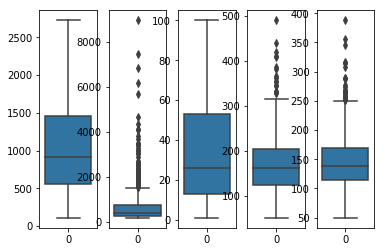

In [8]:
fig,axes=plt.subplots(nrows=1,ncols=5,num=5)
sb.boxplot(data=data['Distance'],ax=axes[0])
sb.boxplot(data=data['Average weekly passengers'],ax=axes[1])
sb.boxplot(data=data['market share'],ax=axes[2])
sb.boxplot(data=data['Average fare'],ax=axes[3])
sb.boxplot(data=data['price'],ax=axes[4])

Q2. Remove the outliers from the data (5 points)

In [9]:
#In order to remove the outliers powertransformer is used

pt = PowerTransformer(method='yeo-johnson')
pt.fit(data)
data_transformed=pd.DataFrame(pt.transform(data),columns=['Average Fare','Distance','Average weekly passengers','market share','Average fare','price'])
data_transformed.head(5)

,Average Fare,Distance,Average weekly passengers,market share,Average fare,price
0,-0.869060,-0.791706,0.019958,1.228113,-0.889724,-0.630019
1,-0.696259,-0.080311,-0.731273,-0.462350,-0.639668,-0.428285
2,0.943160,-0.094632,-1.257639,-1.733315,0.957781,0.610983
3,-2.005984,-1.580154,0.525426,1.732623,-1.960926,-1.954799
4,0.003953,-0.341701,-0.497047,-0.570949,0.050975,0.177317


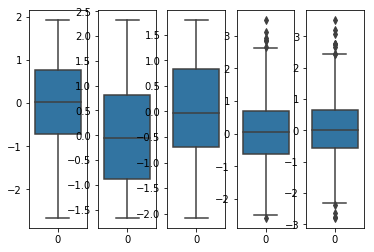

In [10]:
#As evident from boxplots, major outliers have been removed from the columns 'Average weekly passengers','Average fare' and 'price'
#Few outliers can be tolerated

fig,axes=plt.subplots(nrows=1,ncols=5,num=5)
sb.boxplot(data=data_transformed['Distance'],ax=axes[0])
sb.boxplot(data=data_transformed['Average weekly passengers'],ax=axes[1])
sb.boxplot(data=data_transformed['market share'],ax=axes[2])
sb.boxplot(data=data_transformed['Average fare'],ax=axes[3])
sb.boxplot(data=data_transformed['price'],ax=axes[4])

Q3. Treat “Average Fare” – 3rdColumn as your Dependent Variable and Rest of the columns as Independent Variable. (2.5 points)

In [11]:
X_data = data_transformed[['Distance','Average weekly passengers','market share','Average fare','price']]
Y_data = data_transformed['Average Fare']
print(X_data.head(2),Y_data.head(2))

   Distance  Average weekly passengers  market share  Average fare     price
0 -0.791706                   0.019958      1.228113     -0.889724 -0.630019
1 -0.080311                  -0.731273     -0.462350     -0.639668 -0.428285 0   -0.869060
1   -0.696259
Name: Average Fare, dtype: float64


Q4. Drop the independent variables which has less than 0.1 correlation with the dependent variable (5 points)

In [12]:
X_data.corrwith(Y_data)

Distance                     0.638163
Average weekly passengers   -0.191551
market share                -0.455051
Average fare                 0.985627
price                        0.891525
dtype: float64

In [13]:
#As is evident from corelation matrix above, "Average weekly passengers" is very co related with depenent variable("Average Fare")
#Hence, the column "Average weekly passengers" can be dropped from data set.

X_data=X_data.drop(columns=['Average weekly passengers'])
X_data.head(2)

,Distance,market share,Average fare,price
0,-0.791706,1.228113,-0.889724,-0.630019
1,-0.080311,-0.462350,-0.639668,-0.428285


Q5. Create scatter Plot of Independent Variable vs Dependent Variable. (2.5 points)

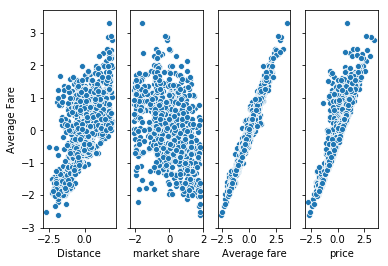

In [16]:
fig,axes=plt.subplots(nrows=1,ncols=4,num=4,sharey=True)
sb.scatterplot(x=X_data['Distance'],y=Y_data,ax=axes[0])
sb.scatterplot(x=X_data['market share'],y=Y_data,ax=axes[1])
sb.scatterplot(x=X_data['Average fare'],y=Y_data,ax=axes[2])
sb.scatterplot(x=X_data['price'],y=Y_data,ax=axes[3])

Q6. Divide the data set into training and test data set and build a Multiple Linear Regression model. (5 points)

In [18]:
train_X,test_X,train_Y,test_Y = train_test_split(X_data,Y_data,test_size = 0.2,shuffle=True)
print(train_X.shape,test_X.shape,train_Y.shape,test_Y.shape)

(800, 4) (200, 4) (800,) (200,)


In [20]:
reg_model = LinearRegression()
reg_model.fit(train_X,train_Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Q7. Print the coefficients & intercepts of the linear regression model (5 points)

In [21]:
reg_model.coef_

array([ 0.00799198, -0.02000895,  0.82287106,  0.1707444 ])

In [22]:
reg_model.intercept_

-0.0019632737678654377

Q8. Print the accuracy of the overall model (2.5 points)

In [23]:
reg_model.score(test_X,test_Y)

0.9769213026139689

In [30]:
mean_abs_error=mean_absolute_error(test_Y,reg_model.predict(test_X))
mean_sq_error = mean_squared_error(test_Y,reg_model.predict(test_X))
r2_sc = r2_score(test_Y,reg_model.predict(test_X))
print('Mean absolute error {}'.format(mean_abs_error))
print('Mean squared error {}'.format(mean_sq_error))
print('R2 score {}'.format(r2_sc))

Mean absolute error 0.10761277471634637
Mean squared error 0.021174997487008948
R2 score 0.9769213026139689
